# Training an ML Model on Tensorflow Datasets
## Prerequisites

In [1]:
import json
import os
from typing import Callable, Optional, List

import numpy as np
import pandas as pd
import tensorflow as tf
from mmproteo.utils import log, paths, utils, visualization
from mmproteo.utils.formats.tf_dataset import DatasetLoader
from mmproteo.utils.ml import callbacks, evaluation, layers, losses

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 1000)

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"]="7"

In [4]:
#tf.debugging.set_log_device_placement(True)
GPUs = tf.config.list_physical_devices('GPU')
GPUs

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Configuration

In [5]:
%pwd

'/hpi/fs00/home/mirko.krause/masterthesis/pride-downloader/notebooks'

In [6]:
# DATA_SOURCE = 'pride'
DATA_SOURCE = 'pdeep'

In [7]:
if DATA_SOURCE == 'pride':
    PROJECT = "PXD010000"
    DUMP_PATH = os.path.join("/scratch/mirko.krause/dumps/", PROJECT)
elif DATA_SOURCE == 'pdeep':
    DUMP_PATH = "/scratch/mirko.krause/pdeep"
else:
    assert False

In [8]:
print(f"dump path = {DUMP_PATH}")
THREAD_COUNT = min(int(os.cpu_count()/2), 16)
TRAINING_COLUMNS_DUMP_PATH = os.path.join(DUMP_PATH, "training_columns")
FILES_PATH = os.path.join(TRAINING_COLUMNS_DUMP_PATH, "*_mzmlid.parquet")
STATISTICS_FILE_PATH = os.path.join(TRAINING_COLUMNS_DUMP_PATH, "statistics.parquet")
DATASET_DUMP_PATH = os.path.join(TRAINING_COLUMNS_DUMP_PATH, "tf_datasets")
PROCESSING_FILE_PATH = os.path.join(DATASET_DUMP_PATH, "processing_info.json")

dump path = /scratch/mirko.krause/pdeep


In [9]:
SEQ = 'peptide_sequence'

In [10]:
logger = log.create_logger(
    name='mmproteo_dense_model',
    verbose=True,
    log_dir=DUMP_PATH,
)

2021-10-24 14:22:22,104 - mmproteo_dense_model: Logging to file '/scratch/mirko.krause/pdeep/mmproteo_dense_model.log' and to stderr


In [11]:
with open(PROCESSING_FILE_PATH, 'r') as file:
    PROCESSING_INFO = json.loads(file.read())
PROCESSING_INFO

{'padding_characters': {'peptide_sequence': '_',
  'mz_array': 0.0,
  'intensity_array': 0.0},
 'padding_lengths': {'mz_array': 89,
  'intensity_array': 89,
  'peptide_sequence': 30},
 'idx_to_char': {'2': 'A',
  '3': 'C',
  '4': 'D',
  '5': 'E',
  '6': 'F',
  '7': 'G',
  '8': 'H',
  '9': 'I',
  '10': 'K',
  '11': 'L',
  '12': 'M',
  '13': 'N',
  '14': 'P',
  '15': 'Q',
  '16': 'R',
  '17': 'S',
  '18': 'T',
  '19': 'V',
  '20': 'W',
  '21': 'Y',
  '0': '_',
  '1': 'EOS'},
 'normalization': {'intensity_array': '<function base_peak_normalize at 0x7f01b581c160>'},
 'split_value_columns': None,
 'training_data_columns': ['mz_array', 'intensity_array'],
 'target_data_columns': ['peptide_sequence'],
 'element_spec': '((TensorSpec(shape=(89,), dtype=tf.float64, name=None), TensorSpec(shape=(89,), dtype=tf.float64, name=None)), (TensorSpec(shape=(30,), dtype=tf.int8, name=None),))',
 'eos_idx': 1}

In [12]:
idx_to_char = {int(idx): char for idx, char in PROCESSING_INFO["idx_to_char"].items()}
char_to_idx = {char: idx for idx, char in idx_to_char.items()}

## Loading Tensorflow Datasets

In [13]:
KEEP_CACHE = True

In [14]:
TRAIN_TYPE = 'Train'
TEST_TYPE = 'Test'
EVAL_TYPE = 'Eval'

In [15]:
def find_grouping_path_position(cols: Optional[List[str]], prefered_item: str, alternative_index: int = -1) -> int:
    res = alternative_index
    if cols is not None:
        try:
            res = cols.index(prefered_item) - len(cols)
        except ValueError:
            pass
    return res

In [16]:
grouping_path_position = find_grouping_path_position(
    cols=PROCESSING_INFO['split_value_columns'],
    prefered_item='species',
    alternative_index=-1,
)
grouping_path_position

-1

In [17]:
dataset_file_paths = paths.assign_wildcard_paths_to_splits_grouped_by_path_position_value(
    wildcard_path = os.path.join(
        DATASET_DUMP_PATH, 
        '*',  # filename
        *(['*' for _ in PROCESSING_INFO['split_value_columns'] or []])
    ),
    path_position = grouping_path_position,
    splits = {
            TRAIN_TYPE: 0.8,
            TEST_TYPE: 0.9,
            EVAL_TYPE: 1.0
        },
    paths_dump_file = os.path.join(
            DATASET_DUMP_PATH,
            "dataset_file_paths.json"
        ),
    skip_existing = KEEP_CACHE,
    logger = logger
)

print()
print("assigned dataset files:")
visualization.print_list_length_in_dict(dataset_file_paths)


assigned dataset files:
#Train = 22
e.g.: /scratch/mirko.krause/pdeep/training_columns/tf_datasets/file_12.parquet
#Test = 3
e.g.: /scratch/mirko.krause/pdeep/training_columns/tf_datasets/file_10.parquet
#Eval = 3
e.g.: /scratch/mirko.krause/pdeep/training_columns/tf_datasets/file_6.parquet


2021-10-24 14:22:22,125 - mmproteo_dense_model: found file paths dump '/scratch/mirko.krause/pdeep/training_columns/tf_datasets/dataset_file_paths.json'


### Loading corresponding TF datasets

In [18]:
element_spec = eval(PROCESSING_INFO['element_spec'], {}, {'TensorSpec':tf.TensorSpec, 'tf':tf})
element_spec

((TensorSpec(shape=(89,), dtype=tf.float64, name=None),
  TensorSpec(shape=(89,), dtype=tf.float64, name=None)),
 (TensorSpec(shape=(30,), dtype=tf.int8, name=None),))

In [19]:
# initialize Tensorflow (might take several minutes (~5 minutes per GPU with 40GB VRAM each))
logger.debug("started initializing tensorflow by creating a first dataset")
tf.data.Dataset.range(5)
logger.info("finished initializing tensorflow")

2021-10-24 14:22:22,131 - mmproteo_dense_model: DEBUG: started initializing tensorflow by creating a first dataset
2021-10-24 14:28:40,687 - mmproteo_dense_model: finished initializing tensorflow


In [20]:
ds_options = tf.data.Options()
ds_options.experimental_threading.private_threadpool_size = THREAD_COUNT
ds_options.experimental_threading.max_intra_op_parallelism = THREAD_COUNT

In [21]:
BATCH_SIZE=32

In [22]:
datasets = DatasetLoader(
    element_spec=element_spec,
    batch_size=BATCH_SIZE,
    shuffle_buffer_size=100_000,
    thread_count=min(int(os.cpu_count()/4), 4),
    keep_cache=KEEP_CACHE,
    logger=logger,
    run_benchmarks=False,
    options=ds_options,
).load_datasets_by_type(dataset_file_paths)
datasets

2021-10-24 14:28:40,700 - mmproteo_dense_model: DEBUG: preparing dataset 'Train' with 22 paths
2021-10-24 14:28:40,703 - mmproteo_dense_model: DEBUG: applied options to dataset 'Train'
2021-10-24 14:28:40,752 - mmproteo_dense_model: DEBUG: loaded dataset 'Train' interleaved
2021-10-24 14:28:40,752 - mmproteo_dense_model: DEBUG: skipped caching dataset 'Train'
2021-10-24 14:28:40,753 - mmproteo_dense_model: DEBUG: shuffled dataset 'Train'
2021-10-24 14:28:40,753 - mmproteo_dense_model: DEBUG: batched dataset 'Train'
2021-10-24 14:28:40,753 - mmproteo_dense_model: DEBUG: configured prefetching for dataset 'Train'
2021-10-24 14:28:40,754 - mmproteo_dense_model: DEBUG: skipped benchmarking dataset 'Train'
2021-10-24 14:28:40,754 - mmproteo_dense_model: prepared dataset 'Train'
2021-10-24 14:28:40,754 - mmproteo_dense_model: DEBUG: preparing dataset 'Test' with 3 paths
2021-10-24 14:28:40,754 - mmproteo_dense_model: DEBUG: applied options to dataset 'Test'
2021-10-24 14:28:40,761 - mmproteo

{'Train': <PrefetchDataset shapes: (((32, 89), (32, 89)), ((32, 30),)), types: ((tf.float64, tf.float64), (tf.int8,))>,
 'Test': <PrefetchDataset shapes: (((32, 89), (32, 89)), ((32, 30),)), types: ((tf.float64, tf.float64), (tf.int8,))>,
 'Eval': <PrefetchDataset shapes: (((32, 89), (32, 89)), ((32, 30),)), types: ((tf.float64, tf.float64), (tf.int8,))>}

## Building the Tensorflow Model

In [23]:
from tensorflow.python.keras.metrics import MeanMetricWrapper
from tensorflow.python.ops import array_ops, math_ops
from tensorflow.python.keras import backend
from tensorflow.python.framework import ops
from tensorflow.python.keras import backend as K

In [24]:
def jaccard_distance(elem):
    i_true, i_pred = elem[0], elem[1]
    unique_true, _ = tf.unique(i_true)
    unique_pred, _ = tf.unique(i_pred)
    n_unique_true = tf.shape(unique_true)[0]
    n_unique_pred = tf.shape(unique_pred)[0]
    unique_all, _ = tf.unique(tf.concat(values=[unique_true, unique_pred], axis=-1))
    n_unique_all = tf.shape(unique_all)[0]
    n_overlap = n_unique_true + n_unique_pred - n_unique_all
    return n_overlap / n_unique_all

def jaccard_batch_distance(y_true, y_pred):
    y_pred = ops.convert_to_tensor_v2_with_dispatch(y_pred)
    y_true = ops.convert_to_tensor_v2_with_dispatch(y_true)
    y_pred_rank = y_pred.shape.ndims
    y_true_rank = y_true.shape.ndims
    # If the shape of y_true is (num_samples, 1), squeeze to (num_samples,)
    if (y_true_rank is not None) and (y_pred_rank is not None) and (len(
            backend.int_shape(y_true)) == len(backend.int_shape(y_pred))):
        y_true = array_ops.squeeze(y_true, [-1])
    y_pred = math_ops.argmax(y_pred, axis=-1)

    # If the predicted output and actual output types don't match, force cast them
    # to match.
    if backend.dtype(y_pred) != backend.dtype(y_true):
        y_pred = math_ops.cast(y_pred, backend.dtype(y_true))
    
    # 0th dimension is the batch
    jaccard = tf.map_fn(fn=jaccard_distance, elems=(y_true, y_pred), fn_output_signature=tf.float64)
    return math_ops.cast(jaccard, backend.floatx())
    

class JaccardBatchDistance(MeanMetricWrapper):
    def __init__(self, name='jaccard_batch_distance', dtype=None):
        super(JaccardBatchDistance, self).__init__(
            jaccard_batch_distance, name, dtype=dtype)

In [25]:
def leuvenshtein_sparse_tensor_batch_distance(y_true: tf.sparse.SparseTensor, y_pred: tf.sparse.SparseTensor) -> tf.Tensor:
    return tf.edit_distance(
        hypothesis=y_pred,
        truth=y_true,
        normalize=False,
    )

def leuvenshtein_batch_distance(y_true: tf.Tensor, y_pred: tf.Tensor, sparse_pred: bool = True) -> tf.Tensor:
    y_pred = ops.convert_to_tensor_v2_with_dispatch(y_pred)
    y_true = ops.convert_to_tensor_v2_with_dispatch(y_true)
    
    if sparse_pred:
        y_pred = math_ops.argmax(y_pred, axis=-1)
    
    y_pred = tf.sparse.from_dense(y_pred)
    y_true = tf.sparse.from_dense(y_true)

    # If the predicted output and actual output types don't match, force cast them
    # to match.
    if backend.dtype(y_pred) != backend.dtype(y_true):
        y_pred = math_ops.cast(y_pred, backend.dtype(y_true))
    
    # 0th dimension is the batch
    leuvenshtein = leuvenshtein_sparse_tensor_batch_distance(y_true, y_pred)
    return math_ops.cast(leuvenshtein, backend.floatx())
    

class LeuvenshteinBatchDistance(MeanMetricWrapper):
    def __init__(self, name='leuvenshtein_batch_distance', dtype=None):
        super(LeuvenshteinBatchDistance, self).__init__(
            leuvenshtein_batch_distance, name, dtype=dtype)

In [26]:
input_layers_list, masked_input_layers_list = layers.create_masked_input_layers(
    [
        layers.InputLayerConfiguration(
            name=col,
            shape=PROCESSING_INFO['padding_lengths'][col],
            mask_value=PROCESSING_INFO['padding_characters'][col]
        )
        for col in PROCESSING_INFO['training_data_columns']
    ]
)
print(input_layers_list)
print(masked_input_layers_list)

[<KerasTensor: shape=(None, 89) dtype=float32 (created by layer 'mz_array')>, <KerasTensor: shape=(None, 89) dtype=float32 (created by layer 'intensity_array')>]
[<KerasTensor: shape=(None, 89) dtype=float32 (created by layer 'masked_mz_array')>, <KerasTensor: shape=(None, 89) dtype=float32 (created by layer 'masked_intensity_array')>]


In [27]:
x = tf.stack(
    values=masked_input_layers_list, 
    axis=-1,
)

x = tf.keras.layers.Flatten(name="flattened_masked_inputs")(x)

for _ in range(4):
    x = tf.keras.layers.Dense(2**11)(x)
    #x = tf.keras.layers.Dropout(0.1)(x)

x = tf.keras.layers.Dense(PROCESSING_INFO['padding_lengths'][SEQ]*len(idx_to_char))(x)

x = tf.reshape(x,(-1, PROCESSING_INFO['padding_lengths'][SEQ], len(idx_to_char)))

x = tf.keras.activations.softmax(x)

model = tf.keras.Model(
    inputs=input_layers_list, 
    outputs=x, 
    name=f"mmproteo_dense_{DATA_SOURCE}_{utils.get_current_time_str()}")
model.compile(
    optimizer=tf.keras.optimizers.Adam(
        learning_rate = 10**-5
    ),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=[
        tf.keras.metrics.SparseCategoricalAccuracy(),
        JaccardBatchDistance(),
        LeuvenshteinBatchDistance(),
    ]
)

In [28]:
MODEL_PATH = os.path.join(DUMP_PATH, "models", model.name)
MODEL_PATH

'/scratch/mirko.krause/pdeep/models/mmproteo_dense_pdeep_20211024-142841'

In [29]:
utils.ensure_dir_exists(MODEL_PATH)

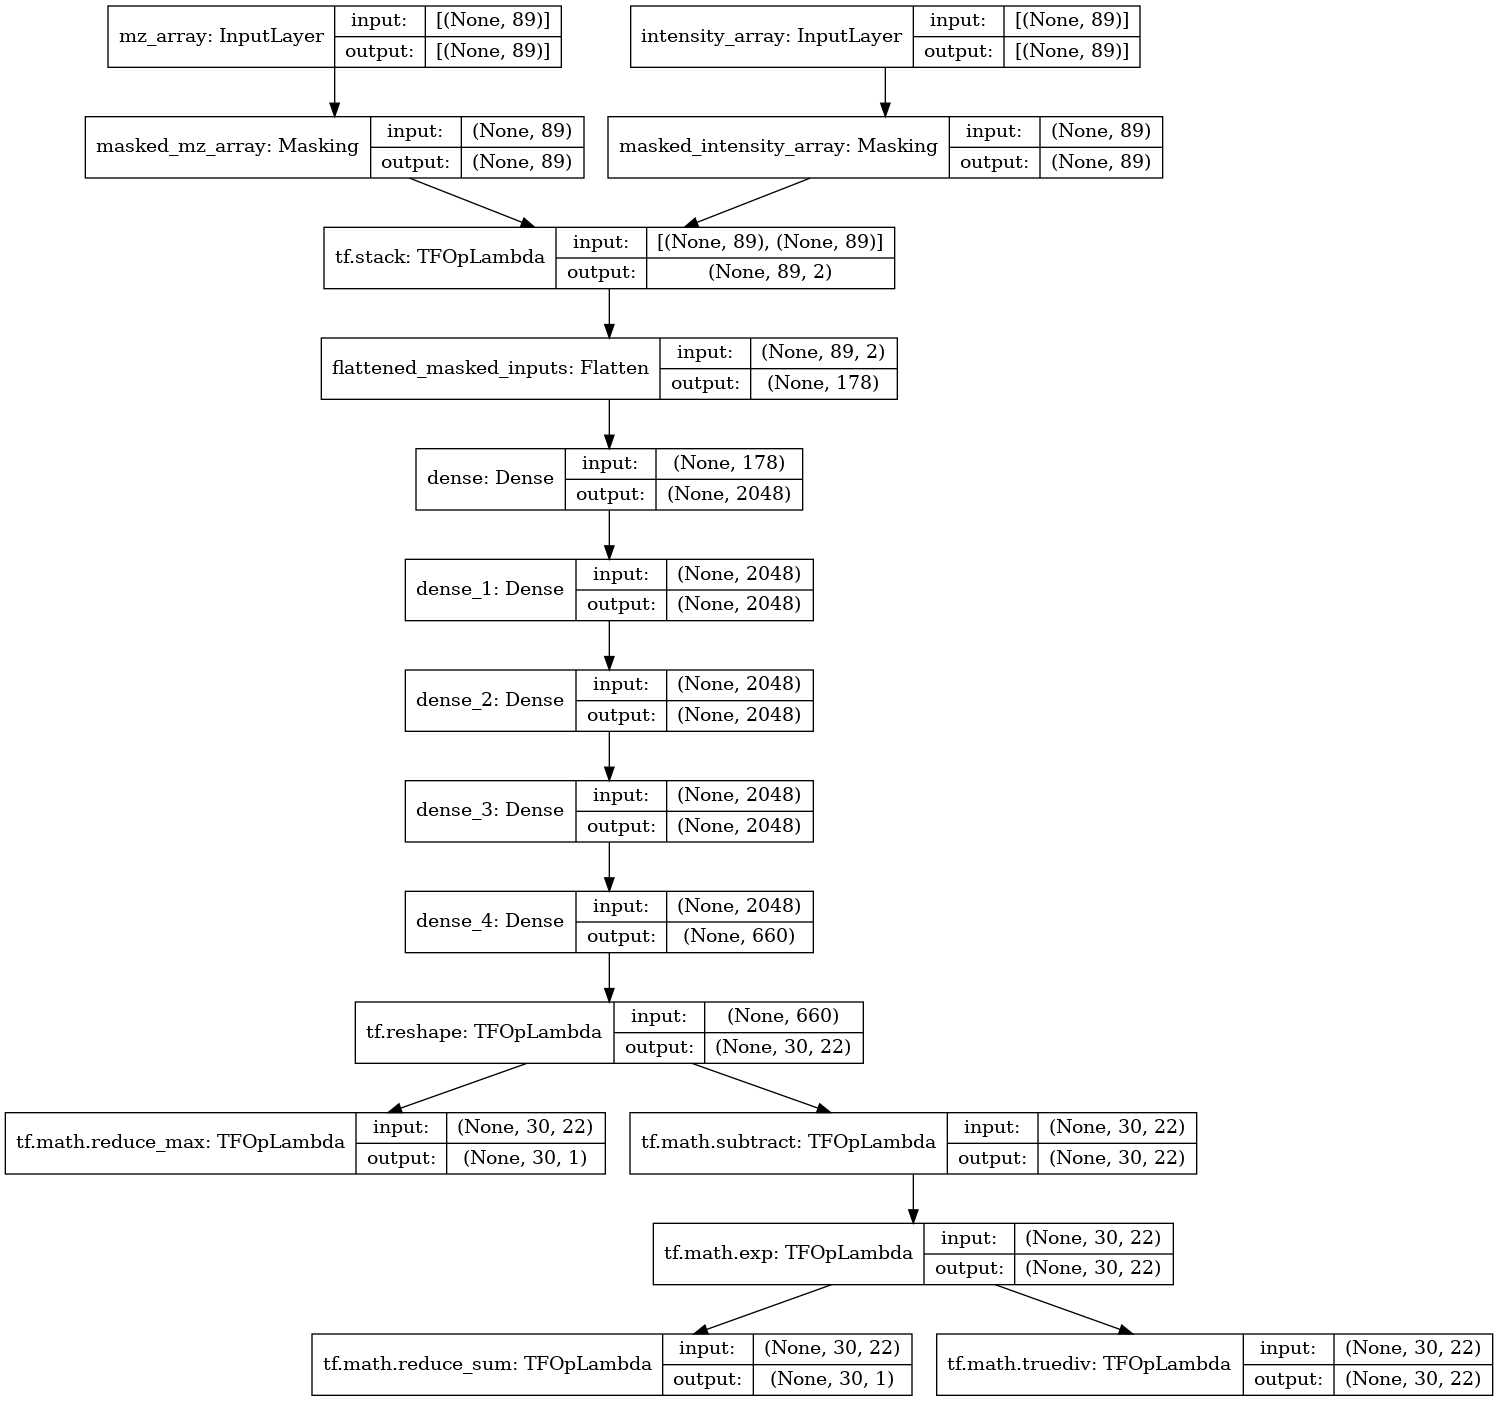

In [30]:
tf.keras.utils.plot_model(
    model=model,
    to_file=os.path.join(MODEL_PATH, "model.png"),
    show_shapes=True
)

In [31]:
with open(os.path.join(MODEL_PATH, "summary.txt"), 'w') as file:
    def write_lines(line: str) -> None:
        file.write(line)
        file.write("\n")
    model.summary(print_fn=write_lines)
model.summary()

Model: "mmproteo_dense_pdeep_20211024-142841"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
mz_array (InputLayer)           [(None, 89)]         0                                            
__________________________________________________________________________________________________
intensity_array (InputLayer)    [(None, 89)]         0                                            
__________________________________________________________________________________________________
masked_mz_array (Masking)       (None, 89)           0           mz_array[0][0]                   
__________________________________________________________________________________________________
masked_intensity_array (Masking (None, 89)           0           intensity_array[0][0]            
_______________________________________________________________

In [32]:
with open(os.path.join(MODEL_PATH, "model.json"), 'w') as file:
    file.write(model.to_json())

In [33]:
with open(os.path.join(MODEL_PATH, "model.yaml"), 'w') as file:
    file.write(model.to_yaml())

## Training the Tensorflow Model

In [34]:
callback_list = callbacks.create_callbacks(
            tensorboard=True,
            progressbar=False,
            reduce_lr=False,
            early_stopping=False,
            checkpoints=False,
            csv=True,
            base_path=MODEL_PATH,
)
callback_list

In [35]:
training_dataset = datasets[TRAIN_TYPE].repeat()
validation_dataset = datasets[TEST_TYPE].repeat()

In [36]:
STEPS_PER_EPOCH = 5_000

In [37]:
model.fit(
    x=training_dataset,
    validation_data=validation_dataset, 
    validation_steps=STEPS_PER_EPOCH // 5,
    epochs=100,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=callback_list,
)

Epoch 1/100
5000/5000 [==============================] - 174s 15ms/step - loss: 8.9322 - sparse_categorical_accuracy: 0.4455 - jaccard_batch_distance: 0.4585 - leuvenshtein_batch_distance: 14.8327 - val_loss: 9.8746 - val_sparse_categorical_accuracy: 0.3874 - val_jaccard_batch_distance: 0.4457 - val_leuvenshtein_batch_distance: 15.9199
Epoch 2/100
5000/5000 [==============================] - 77s 15ms/step - loss: 8.6109 - sparse_categorical_accuracy: 0.4658 - jaccard_batch_distance: 0.4522 - leuvenshtein_batch_distance: 14.1231 - val_loss: 9.8985 - val_sparse_categorical_accuracy: 0.3859 - val_jaccard_batch_distance: 0.5031 - val_leuvenshtein_batch_distance: 15.8960
Epoch 3/100
2604/5000 [==============>...............] - ETA: 30s - loss: 8.3158 - sparse_categorical_accuracy: 0.4841 - jaccard_batch_distance: 0.4677 - leuvenshtein_batch_distance: 13.6378

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



5000/5000 [==============================] - 75s 15ms/step - loss: 7.9249 - sparse_categorical_accuracy: 0.5083 - jaccard_batch_distance: 0.4517 - leuvenshtein_batch_distance: 13.0162 - val_loss: 9.7599 - val_sparse_categorical_accuracy: 0.3945 - val_jaccard_batch_distance: 0.5007 - val_leuvenshtein_batch_distance: 15.8555
Epoch 14/100
5000/5000 [==============================] - 77s 15ms/step - loss: 8.6609 - sparse_categorical_accuracy: 0.4627 - jaccard_batch_distance: 0.4708 - leuvenshtein_batch_distance: 14.0851 - val_loss: 9.7861 - val_sparse_categorical_accuracy: 0.3929 - val_jaccard_batch_distance: 0.4975 - val_leuvenshtein_batch_distance: 15.7758
Epoch 15/100
5000/5000 [==============================] - 76s 15ms/step - loss: 8.6634 - sparse_categorical_accuracy: 0.4625 - jaccard_batch_distance: 0.4843 - leuvenshtein_batch_distance: 14.0889 - val_loss: 9.7755 - val_sparse_categorical_accuracy: 0.3935 - val_jaccard_batch_distance: 0.4723 - val_leuvenshtein_batch_distance: 15.7592

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



5000/5000 [==============================] - 75s 15ms/step - loss: 11.5535 - sparse_categorical_accuracy: 0.2832 - jaccard_batch_distance: 0.5500 - leuvenshtein_batch_distance: 18.8250 - val_loss: 9.9468 - val_sparse_categorical_accuracy: 0.3829 - val_jaccard_batch_distance: 0.5049 - val_leuvenshtein_batch_distance: 16.2154
Epoch 27/100
5000/5000 [==============================] - 76s 15ms/step - loss: 10.5268 - sparse_categorical_accuracy: 0.3469 - jaccard_batch_distance: 0.5275 - leuvenshtein_batch_distance: 17.1157 - val_loss: 9.9450 - val_sparse_categorical_accuracy: 0.3830 - val_jaccard_batch_distance: 0.5082 - val_leuvenshtein_batch_distance: 16.1622
Epoch 28/100
3958/5000 [======================>.......] - ETA: 13s - loss: 11.6133 - sparse_categorical_accuracy: 0.2795 - jaccard_batch_distance: 0.5358 - leuvenshtein_batch_distance: 18.6893

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



5000/5000 [==============================] - 78s 16ms/step - loss: 8.9831 - sparse_categorical_accuracy: 0.4427 - jaccard_batch_distance: 0.4437 - leuvenshtein_batch_distance: 14.6909 - val_loss: 9.8235 - val_sparse_categorical_accuracy: 0.3905 - val_jaccard_batch_distance: 0.5095 - val_leuvenshtein_batch_distance: 15.9665
Epoch 38/100
5000/5000 [==============================] - 78s 16ms/step - loss: 8.8520 - sparse_categorical_accuracy: 0.4508 - jaccard_batch_distance: 0.4620 - leuvenshtein_batch_distance: 14.5051 - val_loss: 9.8528 - val_sparse_categorical_accuracy: 0.3887 - val_jaccard_batch_distance: 0.5131 - val_leuvenshtein_batch_distance: 15.9956
Epoch 39/100
5000/5000 [==============================] - 79s 16ms/step - loss: 9.7844 - sparse_categorical_accuracy: 0.3930 - jaccard_batch_distance: 0.4605 - leuvenshtein_batch_distance: 15.7321 - val_loss: 9.8397 - val_sparse_categorical_accuracy: 0.3895 - val_jaccard_batch_distance: 0.5114 - val_leuvenshtein_batch_distance: 15.9999

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



5000/5000 [==============================] - 86s 17ms/step - loss: 11.7853 - sparse_categorical_accuracy: 0.2688 - jaccard_batch_distance: 0.5340 - leuvenshtein_batch_distance: 18.9753 - val_loss: 9.8349 - val_sparse_categorical_accuracy: 0.3898 - val_jaccard_batch_distance: 0.4948 - val_leuvenshtein_batch_distance: 16.1465
Epoch 50/100
5000/5000 [==============================] - 86s 17ms/step - loss: 11.9371 - sparse_categorical_accuracy: 0.2594 - jaccard_batch_distance: 0.5339 - leuvenshtein_batch_distance: 19.1950 - val_loss: 9.8117 - val_sparse_categorical_accuracy: 0.3913 - val_jaccard_batch_distance: 0.4799 - val_leuvenshtein_batch_distance: 16.0294
Epoch 51/100
4064/5000 [=======================>......] - ETA: 13s - loss: 10.7805 - sparse_categorical_accuracy: 0.3312 - jaccard_batch_distance: 0.4961 - leuvenshtein_batch_distance: 17.2997

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



5000/5000 [==============================] - 79s 16ms/step - loss: 8.9201 - sparse_categorical_accuracy: 0.4466 - jaccard_batch_distance: 0.4450 - leuvenshtein_batch_distance: 14.6744 - val_loss: 9.9765 - val_sparse_categorical_accuracy: 0.3810 - val_jaccard_batch_distance: 0.4915 - val_leuvenshtein_batch_distance: 16.4487
Epoch 62/100
5000/5000 [==============================] - 87s 17ms/step - loss: 8.6771 - sparse_categorical_accuracy: 0.4617 - jaccard_batch_distance: 0.4369 - leuvenshtein_batch_distance: 14.2208 - val_loss: 9.9685 - val_sparse_categorical_accuracy: 0.3815 - val_jaccard_batch_distance: 0.4913 - val_leuvenshtein_batch_distance: 16.4406
Epoch 63/100
2739/5000 [===============>..............] - ETA: 30s - loss: 9.5932 - sparse_categorical_accuracy: 0.4048 - jaccard_batch_distance: 0.4747 - leuvenshtein_batch_distance: 15.7463

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



5000/5000 [==============================] - 77s 15ms/step - loss: 10.1436 - sparse_categorical_accuracy: 0.3707 - jaccard_batch_distance: 0.5090 - leuvenshtein_batch_distance: 16.2857 - val_loss: 9.8087 - val_sparse_categorical_accuracy: 0.3914 - val_jaccard_batch_distance: 0.4991 - val_leuvenshtein_batch_distance: 15.9816
Epoch 73/100
5000/5000 [==============================] - 75s 15ms/step - loss: 10.3422 - sparse_categorical_accuracy: 0.3584 - jaccard_batch_distance: 0.4924 - leuvenshtein_batch_distance: 16.6196 - val_loss: 9.8210 - val_sparse_categorical_accuracy: 0.3907 - val_jaccard_batch_distance: 0.5009 - val_leuvenshtein_batch_distance: 15.9907
Epoch 74/100
5000/5000 [==============================] - 77s 15ms/step - loss: 9.5011 - sparse_categorical_accuracy: 0.4105 - jaccard_batch_distance: 0.4371 - leuvenshtein_batch_distance: 15.3528 - val_loss: 9.7838 - val_sparse_categorical_accuracy: 0.3930 - val_jaccard_batch_distance: 0.4984 - val_leuvenshtein_batch_distance: 15.98

NotFoundError: 2 root error(s) found.
  (0) Not found:  Could not find metadata file.
	 [[{{node LoadDataset}}]]
	 [[IteratorGetNext]]
  (1) Not found:  Could not find metadata file.
	 [[{{node LoadDataset}}]]
	 [[IteratorGetNext]]
	 [[IteratorGetNext/_14]]
0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_1365]

Function call stack:
train_function -> train_function


## Evaluating the Tensorflow Model

In [ ]:
decode_idx: Callable[[np.ndarray], np.ndarray] = np.vectorize(idx_to_char.get)

eval_evaluator = evaluation.SequenceEvaluator(
    dataset=datasets[EVAL_TYPE],
    decode_func=decode_idx,
    batch_size=BATCH_SIZE,
    separator=" ",
    padding_character=PROCESSING_INFO['padding_characters'][SEQ],
)

train_evaluator = evaluation.SequenceEvaluator(
    dataset=datasets[TRAIN_TYPE],
    decode_func=decode_idx,
    batch_size=BATCH_SIZE,
    separator=" ",
    padding_character=PROCESSING_INFO['padding_characters'][SEQ],
)

In [ ]:
train_evaluator.evaluate_model(model)

In [ ]:
eval_df, (x_eval, y_eval, y_pred) = train_evaluator.evaluate_model_visually(
    model=model,
    sample_size=20,
    keep_separator=True,
)
eval_df

In [ ]:
eval_evaluator.evaluate_model(model)

In [ ]:
eval_df, (x_eval, y_eval, y_pred) = eval_evaluator.evaluate_model_visually(
    model=model,
    sample_size=20,
    keep_separator=True,
)
eval_df

In [ ]:
%%javascript
Jupyter.notebook.session.delete();